In [1]:
#!/usr/bin/env python
__author__="Vitali Molchan"

import sys

from bs4 import BeautifulSoup
from string import find,strip, translate

import glob
import time
import dateutil

import re
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns; sns.set()
import difflib
import cPickle

In [2]:
% matplotlib inline
from IPython.display import display, HTML

#### Load www.funda.nl data into DataFrame

Data were collected from <a href="http://www.funda.nl">www.funda.nl </a>
HTML parsing has been performed using BeautifulSoup library.

Funda database contains following attributes:
 - FILE_NAME - name of hte file on the server (used for data collection only)
 - PROPERTY_TYPE: house, appartment
 - PROPERTY_ID - unique identifier (used for data collection only)
 - POSTCODE_NUMBER - digital part of post code (e.g. 2274 from 2274AC)
 - POSTCODE_LETTERS - literal part of post code (e.g. AC from 2274AC)
 - GEMEENTE
 - BUURT
 - OFFER_DATE - date when has been placed on the site
 - SOLD_DATE - date when the property has been sold (according to the site)

In [3]:
dateparser = lambda x: pd.datetime.strptime(x, '%d-%m-%Y') if isinstance(x, str) else np.NaN

In [ ]:
#column_names = ['FILE_NAME','PROPERTY_TYPE','PROPERTY_ID','POSTCODE','GEMEENTE','BUURT','OFFER_DATE','SOLD_DATE','SOLD_PRICE','ASKING_PRICE','VVV_PRICE','YEAR_OF_BUILDING','PLOT_AREA','VOLUME','PLOT_SIZE','NROOMS','TOTAL_FLOORS','PROPERTY_FLOOR','INSULATION_TYPE','HEATING_TYPE','GARDEN_TYPE','GARDEN_AREA','PARKING_TYPE','ENERGY_LABEL','MAKLER_NAME','MAKLER_TEL','dummy'] 
funda = pd.read_csv("20160830/All_houses/20160830_database_cleaned.txt",sep=";",index_col=0,na_values='NA',parse_dates=['SOLD_DATE','OFFER_DATE'])
number_of_lines = funda.shape[0]


In [5]:
def column_type_detector(df):
    columns_types = pd.DataFrame({'dtype':df.dtypes,\
                  '#strings':df.applymap(lambda x: isinstance(x, str)).sum(),
                  '#digits':df.applymap(lambda x: isinstance(x, (int,float,long)) and pd.notnull(x)).sum(),
                  '#na': df.shape[0] - df.count()})
    columns_types = columns_types[['dtype','#strings','#digits','#na']]
    print "Total number of rows is {}".format(df.shape[0])
    return columns_types

In [6]:
column_type_detector(funda)

Total number of rows is 216166


,dtype,#strings,#digits,#na
FILE_NAME,object,216166,0,0
PROPERTY_TYPE,object,216166,0,0
PROPERTY_ID,int64,0,216166,0
POSTCODE,object,197832,0,18334
GEMEENTE,object,197832,0,18334
BUURT,object,203398,0,12768
OFFER_DATE,datetime64[ns],0,0,11865
SOLD_DATE,datetime64[ns],0,0,11865
SOLD_PRICE,object,204248,0,11918
ASKING_PRICE,object,42659,0,173507


In [7]:
funda.dropna(subset = ['SOLD_PRICE'],inplace=True)

In [8]:
funda.head()

,FILE_NAME,PROPERTY_TYPE,PROPERTY_ID,POSTCODE,GEMEENTE,BUURT,OFFER_DATE,SOLD_DATE,SOLD_PRICE,ASKING_PRICE,...,HEATING_TYPE,GARDEN_TYPE,GARDEN_AREA,PARKING_TYPE,ENERGY_LABEL,MAKLER_NAME,MAKLER_TEL,HOUSE_LETTER,HOUSE_NUMBER,STREET
0,appartement-4003351-boerhaavelaan-102-a-featur...,appartement,4003351,3112LM,Schiedam,Rotterdamsedijk,2008-01-15,2015-08-08,129.000,149.000,...,Moederhaard,Achtertuin,50.0,Openbaar parkeren en betaald parkeren,C,Makelaardij Wassenaar,010-4737933,A,102.0,BOERHAAVELAAN
1,appartement-4043458-a-weg-10-25-features.html,appartement,4043458,9581AK,Musselkanaal,Zuid,2007-11-06,2016-03-14,247.500,286.500,...,C.V.-ketel,NaN,NaN,NaN,B,Kral Westen Makelaardij B.V.,0599-581759,NaN,10.0,A WEG
2,appartement-4047711-dingstraat-20-features.html,appartement,4047711,7101GX,Winterswijk,Centrale deel,2007-10-31,2015-11-11,180.000,265.000,...,C.V.-ketel,NaN,NaN,NaN,B,Enning Makelaardij b.v.,0543-516151,NaN,20.0,DINGSTRAAT
3,appartement-4096883-groningerstraat-72-d-featu...,appartement,4096883,9401BM,Assen,Galgenveld,2007-12-19,2016-01-04,175.000,267.550,...,C.V.-ketel,NaN,NaN,NaN,A,Oosting Makelaars,0592-310144,D,72.0,GRONINGERSTRAAT
4,appartement-4104014-weverstraat-11-features.html,appartement,4104014,7271AJ,Borculo,Borculo Oude-Centrum,2008-04-22,2015-09-21,125.000,158.500,...,C.V.-ketel,NaN,NaN,NaN,C,Bijker makelaardij,0545-254444,NaN,11.0,WEVERSTRAAT


Before analysis data need to be converted:
1. OFFER_DATE and SOLD_DATE converted to datetime format
2. ASKING_PRICE and SOLD_PRICE multiplied by 1000 to convert to EUR
3. TOTAL_FLOORS and PROPERTY_FLOOR converted to numeric format

#### Parsing the year of the building

In [9]:
# Check the year of the building
sorted(funda['YEAR_OF_BUILDING'].unique())

[nan,
 '1005',
 '1016',
 '1061',
 '1076',
 '1080',
 '1111',
 '1193',
 '1250',
 '1326',
 '1350',
 '1397',
 '1400',
 '1420',
 '1434',
 '1450',
 '1453',
 '1466',
 '1475',
 '1480',
 '1485',
 '1490',
 '1493',
 '1500',
 '1515',
 '1530',
 '1540',
 '1550',
 '1551',
 '1555',
 '1559',
 '1560',
 '1564',
 '1568',
 '1570',
 '1572',
 '1576',
 '1580',
 '1584',
 '1585',
 '1587',
 '1588',
 '1590',
 '1591',
 '1594',
 '1595',
 '1596',
 '1598',
 '1599',
 '1600',
 '1601',
 '1604',
 '1605',
 '1608',
 '1610',
 '1611',
 '1612',
 '1613',
 '1614',
 '1615',
 '1616',
 '1617',
 '1618',
 '1619',
 '1620',
 '1621',
 '1622',
 '1624',
 '1625',
 '1627',
 '1628',
 '1629',
 '1630',
 '1632',
 '1633',
 '1634',
 '1635',
 '1636',
 '1640',
 '1641',
 '1642',
 '1643',
 '1644',
 '1645',
 '1647',
 '1648',
 '1649',
 '1650',
 '1654',
 '1659',
 '1660',
 '1661',
 '1662',
 '1663',
 '1664',
 '1665',
 '1667',
 '1670',
 '1672',
 '1675',
 '1680',
 '1682',
 '1683',
 '1684',
 '1685',
 '1686',
 '1689',
 '1690',
 '1691',
 '1693',
 '1696',
 '16

At least a couple of items have literal component and need to be converted. There are also some buildings for which we have a range of dates instead of a certain date. 
We can calculate the average value for each date interval. 

In [10]:
def str2year(elem):
    if isinstance(elem,str):
        items = str(elem).split(" ")
        if len(items)==1:
            # Handle items with the years range
            if len(items[0].split("-"))==2:
                begin = int(items[0].split("-")[0])
                end = int(items[0].split("-")[1])
                return (begin+end)/2
            else:
                return int(items[0])
                
        else:
            # Handle items with letters
            return int(items[1])
    else:
        return np.NaN

In [11]:
year_attributes = ['YEAR_OF_BUILDING']

for attr in year_attributes:
    funda[attr] = funda[attr].apply(str2year)

In [ ]:
funda['YEAR_OF_BUILDING'].describe()

#### Converting prices

In [13]:
def str2price(elem):
    try:
        # Handle all values < 1000000
        return float(elem)*1000
    except:
        try:
            # Handle all values >= 1000000
            return float(elem.replace(".",""))
        except:
            print elem
            return -999

In [14]:
price_attributes = ['SOLD_PRICE','ASKING_PRICE']
# Convert price to EUR
#funda[price_attributes] = funda[price_attributes]*100
for attr in price_attributes:
    funda[attr] = funda[attr].apply(str2price)

op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op
op


Only one suspicios item in the dataset

In [15]:
print funda.shape[0]
funda = funda[funda['SOLD_PRICE']!=-999]
print "Number of rows after removing suspicious price data is {}".format(funda.shape[0])

204248
Number of rows after removing suspicious price data is 204248


#### Floor

In [16]:
total_floors = sorted(funda['TOTAL_FLOORS'].unique())
property_floor = sorted(funda['PROPERTY_FLOOR'].unique())
print "Unique items in TOTAL_FLOORS atribute are: \n{}".format(total_floors)
print "Unique items in PROPERTY_FLOOR atribute are: \n{}".format(property_floor)

Unique items in TOTAL_FLOORS atribute are: 
[nan, '1 woonlaag', '1 woonlaag en een kelder', '1 woonlaag en een vliering', '1 woonlaag en een zolder', '1 woonlaag en een zolder met vliering', '1 woonlaag, een vliering en een kelder', '1 woonlaag, een zolder en een kelder', '1 woonlaag, een zolder met vliering en een kelder', '10 woonlagen', '11 woonlagen', '12 woonlagen', '13 woonlagen', '14 woonlagen', '15 woonlagen', '16 woonlagen', '17 woonlagen', '18 woonlagen', '19 woonlagen', '2 woonlagen', '2 woonlagen en een kelder', '2 woonlagen en een vliering', '2 woonlagen en een zolder', '2 woonlagen en een zolder met vliering', '2 woonlagen, een vliering en een kelder', '2 woonlagen, een zolder en een kelder', '2 woonlagen, een zolder met vliering en een kelder', '20 woonlagen', '21 woonlagen', '22 woonlagen', '23 woonlagen', '24 woonlagen', '25 woonlagen', '26 woonlagen', '27 woonlagen', '29 woonlagen', '3 woonlagen', '3 woonlagen en een kelder', '3 woonlagen en een vliering', '3 woonlage

We can replace the description with a certain value. First we can convert the ground floor (*Begane grond* in Dutch) to the same format) 

In [ ]:
funda['PROPERTY_FLOOR'][funda['PROPERTY_FLOOR']=='Begane grond']="0e woonlaag"

# Then we can split the string and extract the first element from each item
funda['PROPERTY_FLOOR'][funda['PROPERTY_FLOOR'].isnull()==False] = funda['PROPERTY_FLOOR'][funda['PROPERTY_FLOOR'].isnull()==False].apply(lambda x: float(strip(x).split()[0][:-1]))
funda['TOTAL_FLOORS'][funda['TOTAL_FLOORS'].isnull()==False] = funda['TOTAL_FLOORS'][funda['TOTAL_FLOORS'].isnull()==False].apply(lambda x: float(strip(x).split()[0]))

# Convert to float
funda['PROPERTY_FLOOR'] = funda['PROPERTY_FLOOR'].astype(float)
funda['TOTAL_FLOORS'] = funda['TOTAL_FLOORS'].astype(float)


#### Processing the NROOMS (number of rooms) attribute 

In [18]:
rooms = sorted(funda['NROOMS'].unique())
print rooms

[nan, '1 kamer', '1 kamer (1 slaapkamer)', '10 kamers', '10 kamers (1 slaapkamer)', '10 kamers (10 slaapkamers)', '10 kamers (2 slaapkamers)', '10 kamers (3 slaapkamers)', '10 kamers (4 slaapkamers)', '10 kamers (5 slaapkamers)', '10 kamers (6 slaapkamers)', '10 kamers (7 slaapkamers)', '10 kamers (8 slaapkamers)', '10 kamers (9 slaapkamers)', '11 kamers', '11 kamers (1 slaapkamer)', '11 kamers (10 slaapkamers)', '11 kamers (11 slaapkamers)', '11 kamers (2 slaapkamers)', '11 kamers (3 slaapkamers)', '11 kamers (4 slaapkamers)', '11 kamers (5 slaapkamers)', '11 kamers (6 slaapkamers)', '11 kamers (7 slaapkamers)', '11 kamers (8 slaapkamers)', '11 kamers (9 slaapkamers)', '12 kamers', '12 kamers (10 slaapkamers)', '12 kamers (11 slaapkamers)', '12 kamers (2 slaapkamers)', '12 kamers (3 slaapkamers)', '12 kamers (4 slaapkamers)', '12 kamers (5 slaapkamers)', '12 kamers (6 slaapkamers)', '12 kamers (7 slaapkamers)', '12 kamers (8 slaapkamers)', '12 kamers (9 slaapkamers)', '13 kamers', '13

A lot of different representations. We can extract total number of rooms only for simplicity.

In [19]:
for room in rooms:
    if isinstance(room,str):
        print room,"-->",''.join([x if x.isalnum()  else " " for x in room.strip()])

1 kamer --> 1 kamer
1 kamer (1 slaapkamer) --> 1 kamer  1 slaapkamer 
10 kamers --> 10 kamers
10 kamers (1 slaapkamer) --> 10 kamers  1 slaapkamer 
10 kamers (10 slaapkamers) --> 10 kamers  10 slaapkamers 
10 kamers (2 slaapkamers) --> 10 kamers  2 slaapkamers 
10 kamers (3 slaapkamers) --> 10 kamers  3 slaapkamers 
10 kamers (4 slaapkamers) --> 10 kamers  4 slaapkamers 
10 kamers (5 slaapkamers) --> 10 kamers  5 slaapkamers 
10 kamers (6 slaapkamers) --> 10 kamers  6 slaapkamers 
10 kamers (7 slaapkamers) --> 10 kamers  7 slaapkamers 
10 kamers (8 slaapkamers) --> 10 kamers  8 slaapkamers 
10 kamers (9 slaapkamers) --> 10 kamers  9 slaapkamers 
11 kamers --> 11 kamers
11 kamers (1 slaapkamer) --> 11 kamers  1 slaapkamer 
11 kamers (10 slaapkamers) --> 11 kamers  10 slaapkamers 
11 kamers (11 slaapkamers) --> 11 kamers  11 slaapkamers 
11 kamers (2 slaapkamers) --> 11 kamers  2 slaapkamers 
11 kamers (3 slaapkamers) --> 11 kamers  3 slaapkamers 
11 kamers (4 slaapkamers) --> 11 kamers 

In [20]:
def str2room(elem):
    if isinstance(elem,str):
        return ''.join([x if x.isalnum()  else " " for x in elem.strip()]).split()[0]
    else:
        return np.NAN

In [21]:
funda['NROOMS'] = funda['NROOMS'].apply(str2room)
funda['NROOMS'] = funda['NROOMS'].astype(float)

u'VVV_PRICE', 
       u'PLOT_AREA', u'VOLUME', u'PLOT_SIZE', 
       , u'INSULATION_TYPE', u'HEATING_TYPE', u'GARDEN_TYPE',
       u'GARDEN_AREA', u'PARKING_TYPE', u'ENERGY_LABEL', u'MAKLER_NAME',
       u'MAKLER_TEL', 

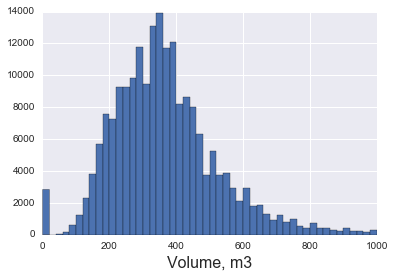

In [22]:
funda['VOLUME'].hist(bins=50)
plt.xlabel("Volume, m3", size=16)


In [23]:
# There are certain cases with very (non-physically) small volume (e.g. less than 10 m3)
funda[funda['VOLUME']<10].count()

FILE_NAME           2828
PROPERTY_TYPE       2828
PROPERTY_ID         2828
POSTCODE            2804
GEMEENTE            2804
BUURT               2819
OFFER_DATE          2828
SOLD_DATE           2828
SOLD_PRICE          2828
ASKING_PRICE         942
VVV_PRICE              0
YEAR_OF_BUILDING    2828
PLOT_AREA           2828
VOLUME              2828
PLOT_SIZE              0
NROOMS              2828
TOTAL_FLOORS        2828
PROPERTY_FLOOR        44
INSULATION_TYPE     1679
HEATING_TYPE        2533
GARDEN_TYPE         2655
GARDEN_AREA          973
PARKING_TYPE         921
ENERGY_LABEL        2086
MAKLER_NAME         2779
MAKLER_TEL          2827
HOUSE_LETTER         254
HOUSE_NUMBER        2807
STREET              2828
dtype: int64

In [24]:
column_type_detector(funda)

Total number of rows is 204248


,dtype,#strings,#digits,#na
FILE_NAME,object,204248,0,0
PROPERTY_TYPE,object,204248,0,0
PROPERTY_ID,int64,0,204248,0
POSTCODE,object,197765,0,6483
GEMEENTE,object,197765,0,6483
BUURT,object,203330,0,918
OFFER_DATE,datetime64[ns],0,0,0
SOLD_DATE,datetime64[ns],0,0,0
SOLD_PRICE,float64,0,204248,0
ASKING_PRICE,float64,0,42659,161589


Several conclusions can be drawn:
     - FILE_NAME, PROPERT_TYPE, PROPERTY_ID attributes don't have missed values
     

In [25]:
# Property types
funda.groupby('PROPERTY_TYPE')['PROPERTY_TYPE'].agg('count')

PROPERTY_TYPE
appartement            60936
bouwgrond               1675
huis                  140321
object                    86
parkeergelegenheid      1230
Name: PROPERTY_TYPE, dtype: int64

This study is used the only data about appartments and houses (huis in Dutch). We can filter out not relevant data.

In [26]:
funda = funda[(funda['PROPERTY_TYPE']=='appartement')|(funda['PROPERTY_TYPE']=='huis')]
print "Number of appartmens and houses is {}".format(funda.shape[0])

Number of appartmens and houses is 201257


In [27]:
column_type_detector(funda)

Total number of rows is 201257


,dtype,#strings,#digits,#na
FILE_NAME,object,201257,0,0
PROPERTY_TYPE,object,201257,0,0
PROPERTY_ID,int64,0,201257,0
POSTCODE,object,195288,0,5969
GEMEENTE,object,195288,0,5969
BUURT,object,200350,0,907
OFFER_DATE,datetime64[ns],0,0,0
SOLD_DATE,datetime64[ns],0,0,0
SOLD_PRICE,float64,0,201257,0
ASKING_PRICE,float64,0,42077,159180


POSTCODE and GEMEENTE attributes have 5969 missed values

In [28]:
missed_postcode = funda[funda['POSTCODE'].isnull()].index
missed_gemeente = funda[funda['GEMEENTE'].isnull()].index
print len(missed_postcode)
print len(missed_gemeente)
print len(set(missed_gemeente)|set(missed_postcode))

5969
5969
5969


Missed postcode and gemeente data are in the same rows. For simplicity these rows can be deleted from the DataFrame (~ 3% data)

In [29]:
funda.dropna(subset=['POSTCODE'],inplace=True)
print "Number of rows after missed POSTCODE deleting is {}".format(funda.shape[0])

Number of rows after missed POSTCODE deleting is 195288


In [30]:
column_type_detector(funda)

Total number of rows is 195288


,dtype,#strings,#digits,#na
FILE_NAME,object,195288,0,0
PROPERTY_TYPE,object,195288,0,0
PROPERTY_ID,int64,0,195288,0
POSTCODE,object,195288,0,0
GEMEENTE,object,195288,0,0
BUURT,object,194555,0,733
OFFER_DATE,datetime64[ns],0,0,0
SOLD_DATE,datetime64[ns],0,0,0
SOLD_PRICE,float64,0,195288,0
ASKING_PRICE,float64,0,41882,153406


In [ ]:
# Year of building attribute
funda['YEAR_OF_BUILDING'][funda['YEAR_OF_BUILDING'].isnull()] = round(funda['YEAR_OF_BUILDING'].mean(),0)

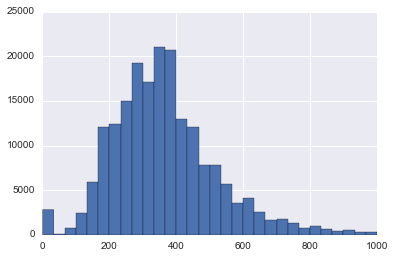

In [32]:
funda['VOLUME'].hist(bins=30)

Assume the average ceiling height is 3 m

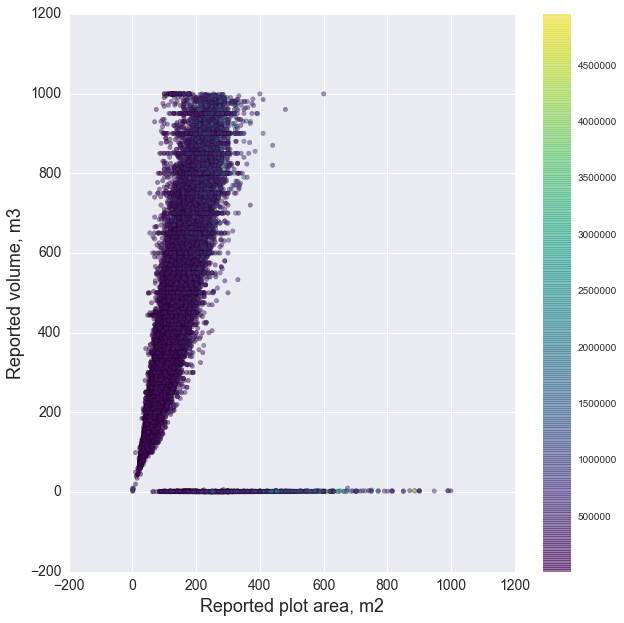

In [33]:
fig = plt.figure(figsize=[10,10])
plt.scatter(funda['PLOT_AREA'],funda['VOLUME'],s=20,alpha=0.5,c=funda['SOLD_PRICE'],cmap='viridis')
plt.xlabel('Reported plot area, m2',size=18)
plt.ylabel('Reported volume, m3',size=18)
plt.tick_params(labelsize=14)
plt.colorbar()

Plot above suggest there are a lot of wrong data in 'VOLUME' attribute. We can try to recalculate the volume WOZ data from CBS database and plot size(m2). But for now just leave these data as it is.

### Gardens

In [71]:
# There are many garden types. We can create syntetic feature GARDEN_TYPE to summarize it
sorted(funda['GARDEN_TYPE'].unique())

[nan,
 'Achtertuin',
 'Achtertuin en patio/atrium',
 'Achtertuin en plaats',
 'Achtertuin en tuin rondom',
 'Achtertuin en voortuin',
 'Achtertuin en zijtuin',
 'Achtertuin en zonneterras',
 'Achtertuin, patio/atrium en plaats',
 'Achtertuin, patio/atrium en voortuin',
 'Achtertuin, patio/atrium en zonneterras',
 'Achtertuin, patio/atrium, plaats en zonneterras',
 'Achtertuin, patio/atrium, plaats, tuin rondom, voortuin, zijtuin en zonneterras',
 'Achtertuin, patio/atrium, voortuin en zijtuin',
 'Achtertuin, patio/atrium, voortuin en zonneterras',
 'Achtertuin, patio/atrium, voortuin, zijtuin en zonneterras',
 'Achtertuin, patio/atrium, zijtuin en voortuin',
 'Achtertuin, plaats en voortuin',
 'Achtertuin, plaats en zijtuin',
 'Achtertuin, plaats en zonneterras',
 'Achtertuin, plaats, tuin rondom, voortuin en zonneterras',
 'Achtertuin, plaats, tuin rondom, voortuin, zijtuin en zonneterras',
 'Achtertuin, plaats, voortuin en zijtuin',
 'Achtertuin, plaats, voortuin en zonneterras',
 'A

In [36]:
# Count the number of properties wich 'null' garden type attribute
funda['GARDEN_TYPE'].isnull().sum()

56493

In [42]:
# Check what is the garden area for such properties
funda['GARDEN_AREA'][funda['GARDEN_TYPE'].isnull()].isnull().sum()

56493

In [ ]:
# Garden flag
funda['GARDEN_FLAG'] = 1.0
funda['GARDEN_FLAG'][funda['GARDEN_TYPE'].isnull()]=0.0

### Property floor

In [80]:
# Assign 0 to PROPERTY_FLOOR attribute for all houses
funda['PROPERTY_FLOOR'][funda['PROPERTY_TYPE']=='huis'].unique()

array([ nan])

In [ ]:
funda['PROPERTY_FLOOR'][funda['PROPERTY_TYPE']=='huis'] = 0

In [82]:
# Only 4079 undefined values
funda['PROPERTY_FLOOR'].isnull().sum()

4079

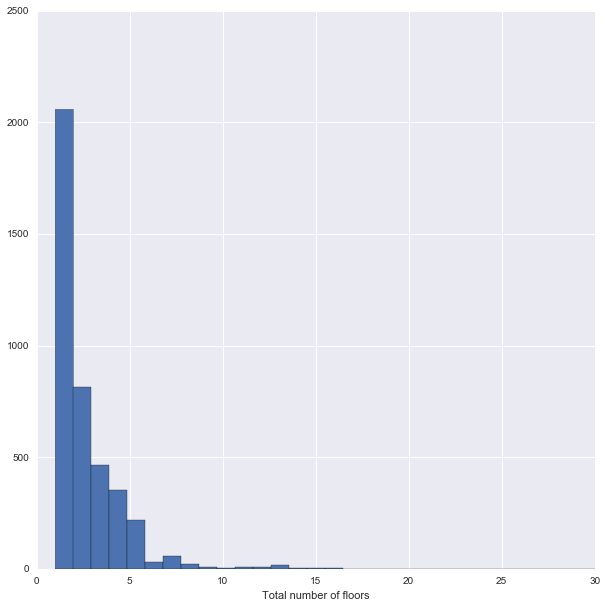

In [83]:
fig = plt.figure(figsize=[10,10])
plt.hist(funda['TOTAL_FLOORS'][funda['PROPERTY_FLOOR'].isnull()],bins=30)
plt.xlabel("Total number of floors")

The majority of the buidings are the only several floors. We can try to use additional features to identify unknow values, e.g. if appartment has garden it is probably on the ground floor.

In [84]:
# We can assign the top floor for all other unknow data
funda['PROPERTY_FLOOR'][funda['PROPERTY_FLOOR'].isnull()] = funda['TOTAL_FLOORS'][funda['PROPERTY_FLOOR'].isnull()]

c:\Users\vitali_molchan\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [85]:
column_type_detector(funda)

Total number of rows is 195288


,dtype,#strings,#digits,#na
FILE_NAME,object,195288,0,0
PROPERTY_TYPE,object,195288,0,0
PROPERTY_ID,int64,0,195288,0
POSTCODE,object,195288,0,0
GEMEENTE,object,195288,0,0
BUURT,object,194555,0,733
OFFER_DATE,datetime64[ns],0,0,0
SOLD_DATE,datetime64[ns],0,0,0
SOLD_PRICE,float64,0,195288,0
ASKING_PRICE,float64,0,41882,153406


In our model we will try to predict the price ('SOLD_PRICE' attribute) of the propery based on several attributes:
 - 'YEAR_OF_BUILDING': Year of the building
 - 'PROPERTY_TYPE': appartment or house
 
 Size of the property
 - 'PLOT_AREA' - area, m2
 - 'VOLUME' - volume, m3
 - 'NROOMS' - number of rooms
 Characteristics of the building
 - 'TOTAL_FLOORS' - number of floors
 - 'PROPERTY_FLOOR' - the actual floor where the property is situated. In case of house the floor is 0
 Garden
 - 'GARDEN_FLAG' - 1 if property has a certain type of garden, 0 in opposite case.
 - 'GARDEN_AREA' - garden area, m2
 Energy label
 - 'ENERGY_LABEL' - almost every property has a energy level characteristic - A (high, modern houses)-G (low, old houses)

Plus we can add additional attributes from CBS databases (different statistical info from every GEMEENTE and BUURT). To link funda and CBS database we need to provide with several additional attributes:
 - POSTCODE
 - GEMEENTE
 - BUURT

Also we can make an attempt to use a geographical info from ZIPCODE database. To do so, We need to export also several attributes from funda:
 - STREET
 - HOUSE_NUMBER
 - HOUSE_LETTER

In [ ]:
funda_features = ['SOLD_PRICE','POSTCODE','GEMEENTE','BUURT','SOLD_DATE','YEAR_OF_BUILDING','PROPERTY_TYPE','PLOT_AREA','VOLUME','NROOMS','TOTAL_FLOORS','PROPERTY_FLOOR','GARDEN_FLAG','GARDEN_AREA','ENERGY_LABEL']

In [314]:
# Save DataFrame
funda.to_pickle("Processed_data/funda.pickle")